In [1]:
import os

import functools as ftools
import itertools as itools

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_c

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf

from tqdm import tqdm

from sklearn.model_selection import train_test_split

## Load dataset

In [2]:
# Where is the data?
data_path = "data"

metadata_filename = "HAM10000_metadata.csv"
preprocesed_image_filenames = "hmnist_{resolution}_{resolution}_{depth}.csv"

In [3]:
# What data to load. change this for a different dataset
image_resolution = 28
color = True

depth = "RGB" if color else "L"
preprocesed_image_filename = preprocesed_image_filenames.format(resolution=image_resolution,depth=depth)

In [4]:
# Load data into dataframes
meta_df = pd.read_csv(data_path + os.sep + metadata_filename)
image_df = pd.read_csv(data_path + os.sep + preprocesed_image_filename)


# Initial visualization

In [5]:
meta_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [6]:
image_df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


# Clean data

In [7]:
# Remove ID labels, they do not contain interpretable information
meta_df = meta_df.drop(["lesion_id","image_id"], axis=1)

# Reorder meta_df columns
cols = meta_df.columns.tolist()

cols[0], cols[-1] = cols[-1], cols[0]
cols[1], cols[-2] = cols[-2], cols[1]

meta_df['age'] = meta_df.age.fillna(value=meta_df.age.mean())

meta_df = meta_df[cols]
meta_df

,localization,sex,age,dx_type,dx
0,scalp,male,80.0,histo,bkl
1,scalp,male,80.0,histo,bkl
2,scalp,male,80.0,histo,bkl
3,scalp,male,80.0,histo,bkl
4,ear,male,75.0,histo,bkl
...,...,...,...,...,...
10010,abdomen,male,40.0,histo,akiec
10011,abdomen,male,40.0,histo,akiec
10012,abdomen,male,40.0,histo,akiec
10013,face,male,80.0,histo,akiec


In [8]:
# Remove "label" from image df, this information is already in meta_df
image_df = image_df.drop(["label"], axis=1)
image_df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,181,208,185,187,208,186,186,206,187,189
10011,2,3,1,38,33,32,121,104,103,132,...,129,96,79,76,24,23,21,3,4,1
10012,132,118,118,167,149,149,175,156,160,184,...,190,204,181,178,181,159,153,172,151,145
10013,160,124,146,164,131,152,167,127,146,169,...,165,185,162,167,184,157,166,185,162,172


# Preprocessing
## Metadata

In [9]:
#categorical columns
cat_df = meta_df.drop(['age'], axis = 1) 
num_df = meta_df.age

In [10]:
le = LabelEncoder()
cat_df_e = cat_df.apply(LabelEncoder().fit_transform)
int2label = {col: cat_df[col].unique() for col in cat_df.columns}

meta_df_e = pd.concat([cat_df_e.iloc[:,:-1], num_df, cat_df_e.iloc[:,-1]], axis=1)
meta_df_e.head()

,localization,sex,dx_type,age,dx
0,11,1,3,80.0,2
1,11,1,3,80.0,2
2,11,1,3,80.0,2
3,11,1,3,80.0,2
4,4,1,3,75.0,2


## Images

In [11]:
img_cols = image_df.columns.tolist()

color_cols = {}
color_cols["Red"] = img_cols[::3]
color_cols["Green"] = img_cols[1::3]
color_cols["Blue"] = img_cols[2::3]

color_dfs = {k : image_df[v] for k,v in color_cols.items()}

In [12]:
r_images = np.reshape(image_df[color_cols["Red"]].to_numpy(),(-1,image_resolution,image_resolution,1))
g_images = np.reshape(image_df[color_cols["Green"]].to_numpy(),(-1,image_resolution,image_resolution,1))
b_images = np.reshape(image_df[color_cols["Blue"]].to_numpy(),(-1,image_resolution,image_resolution,1))

images_np = np.concatenate([r_images,g_images,b_images],axis=-1)

## Train-test split

In [13]:
shuffled_meta = meta_df_e.sample(frac=1)
shuffled_img = images_np[shuffled_meta.index]

In [14]:
# split
test_split = 0.2
test_size = int(len(shuffled_meta)*test_split)

meta_train = shuffled_meta.iloc[test_size:].copy()
meta_test = shuffled_meta.iloc[:test_size].copy()

img_train = shuffled_img[test_size:]
img_test = shuffled_img[:test_size]

In [98]:
split_table = pd.DataFrame(dict(train=meta_train.shape[0],test=meta_test.shape[0]),index=["sample count"])

print(split_table.to_latex())
split_table

\begin{tabular}{lrr}
\toprule
{} &  train &  test \\
\midrule
sample count &   8012 &  2003 \\
\bottomrule
\end{tabular}



,train,test
sample count,8012,2003


# Visualize data once more (in more depth)

## Plots
### Meta

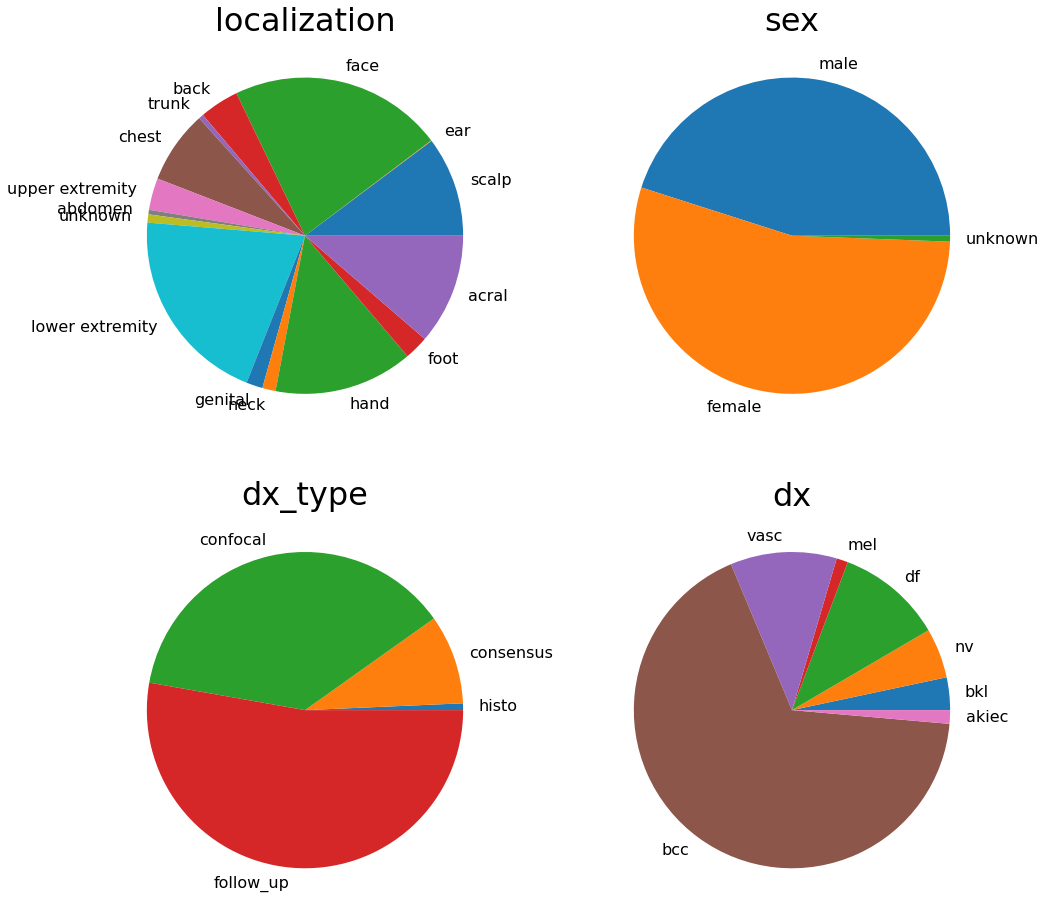

In [16]:
plot_size = 16
textprops = dict(fontsize=plot_size)

categorical_columns =  meta_df.columns.drop("age")

n_pies = len(categorical_columns)
cols = n_pies//2
rows = min(n_pies//2, n_pies//2 + 1, key=lambda x: abs(x - n_pies/2))

fig, axs = plt.subplots(cols,rows)

for i, cc in enumerate(categorical_columns):
    ax = axs[i//2,i%2]
    
    c = meta_train.groupby(cc).size()
    counts = c
    labels = c.keys()
    labels = list(map(int2label[cc].__getitem__,labels))
    
    ax.pie(counts,labels=labels,textprops=textprops)
    ax.set_title(cc,fontsize=plot_size*2)
    
fig.set_size_inches(plot_size,plot_size)
plt.show()

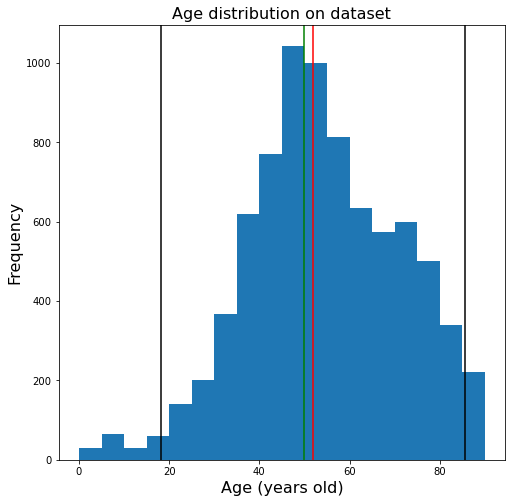

In [17]:
plot_size = 8
std_span = 2 # >75 % data (Chebyshev’s Theorem), > 95% on normal distributions

fig, ax = plt.subplots()

ax.hist(meta_train.age, bins=np.arange(0,95,5))

ax.set_title("Age distribution on dataset",fontsize=plot_size*2)
ax.set_xlabel("Age (years old)",fontsize=plot_size*2)
ax.set_ylabel("Frequency",fontsize=plot_size*2)

age_mean = meta_train.age.mean()
age_std = meta_train.age.std()

ax.axvline(age_mean, color="red") # Mean line
ax.axvline(meta_train.age.median(), color="green") # Median line

ax.axvline(age_mean - age_std*std_span, color="black") # Std lines
ax.axvline(age_mean + age_std*std_span, color="black") 


fig.set_size_inches(plot_size,plot_size)

### Image

In [18]:
## Define metrics
metrics = {}
metrics["mean"] = pd.DataFrame.mean
metrics["median"] = pd.DataFrame.median
metrics["std"] = pd.DataFrame.std
metrics["max"] = pd.DataFrame.max
metrics["min"] = pd.DataFrame.min


#### Image level

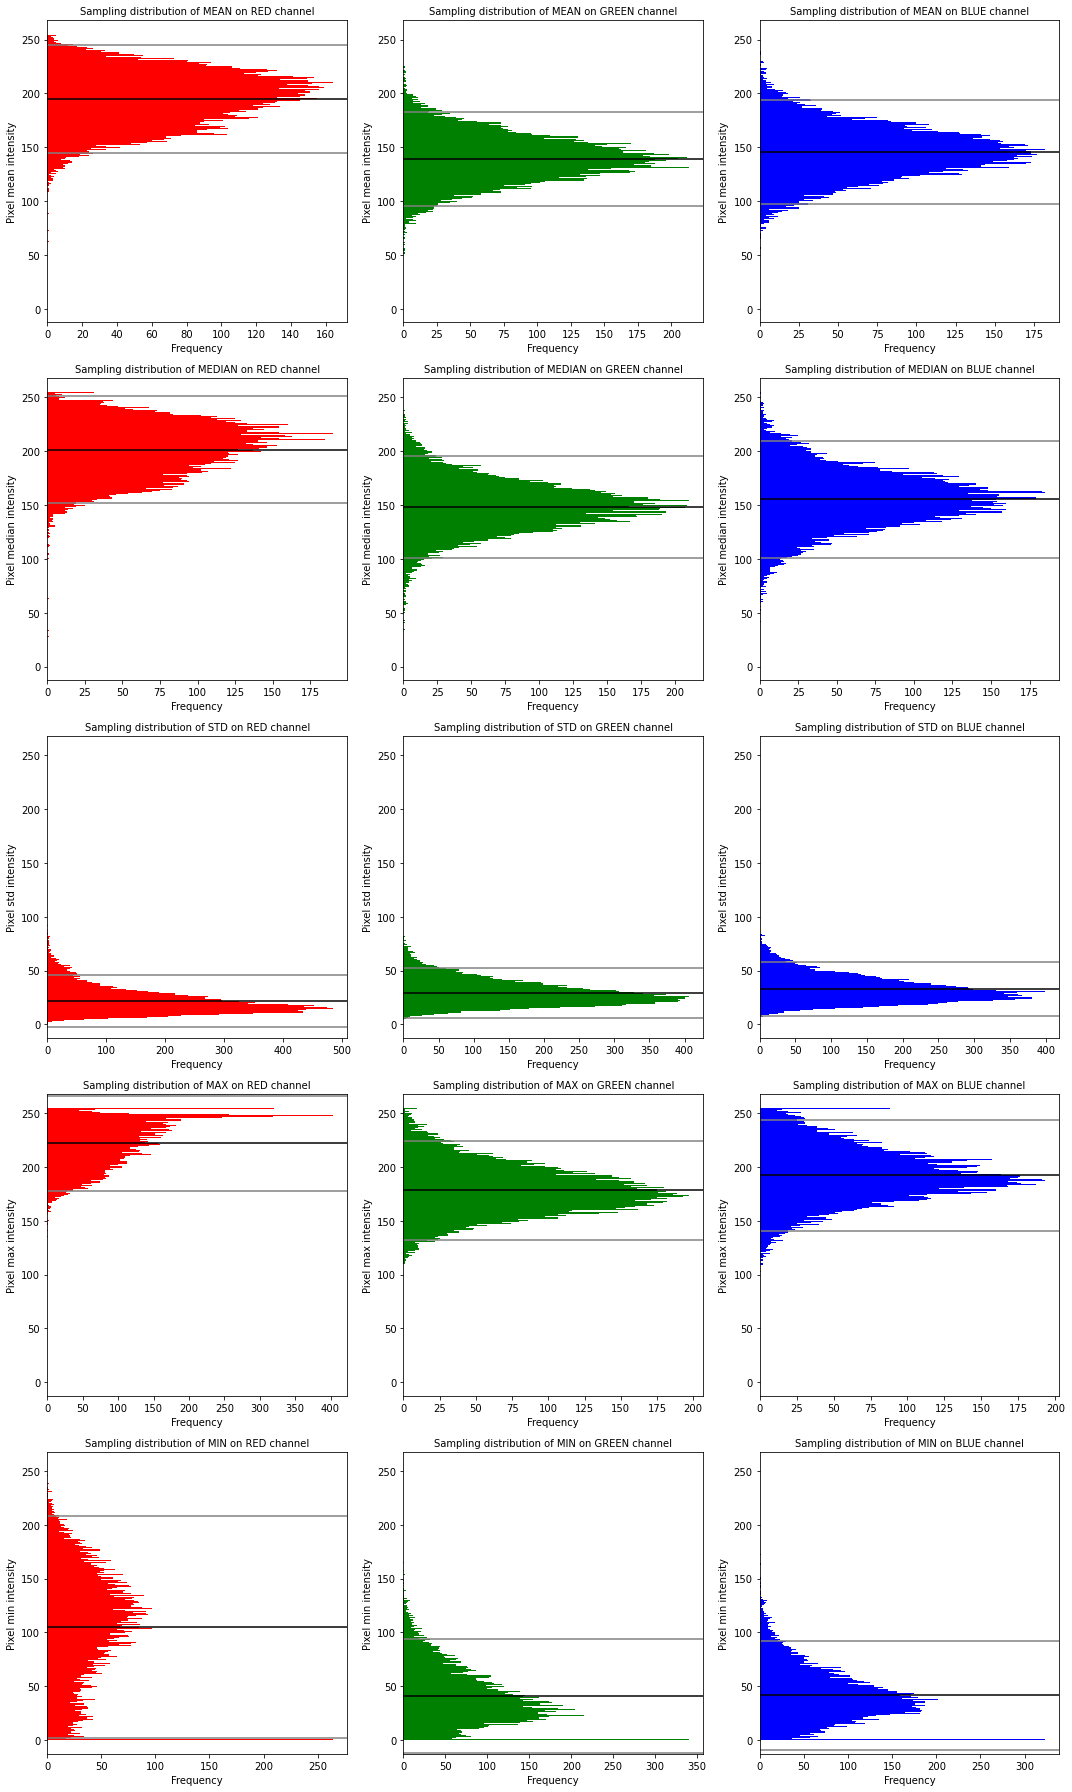

In [19]:
plot_scale = 5
std_span = 2

bins = np.arange(0,256,1)
fig, axs = plt.subplots(len(metrics),len(color_dfs))

for i, (col_name, col_df) in enumerate(color_dfs.items()):
    for j, (metric_name, metric) in enumerate(metrics.items()):
        ax = axs[j,i]
        
        dist = metric(col_df,axis=1)
        ax.hist(dist, bins=bins, color=col_name, orientation="horizontal")
        
        ax.set_title("Sampling distribution of {} on {} channel".format(metric_name.upper(),col_name.upper()),fontsize=plot_scale*2)
        ax.set_ylabel("Pixel {} intensity".format(metric_name),fontsize=plot_scale*2)
        ax.set_xlabel("Frequency",fontsize=plot_scale*2)
        
        mean = dist.mean()
        std = dist.std()
        ax.axhline(mean, color="black") # Mean line

        ax.axhline(mean - std*std_span, color="grey") # Std lines
        ax.axhline(mean + std*std_span, color="grey") 
        

fig.set_size_inches(plot_scale*len(color_dfs),plot_scale*len(metrics))
fig.tight_layout()

#### Pixel level

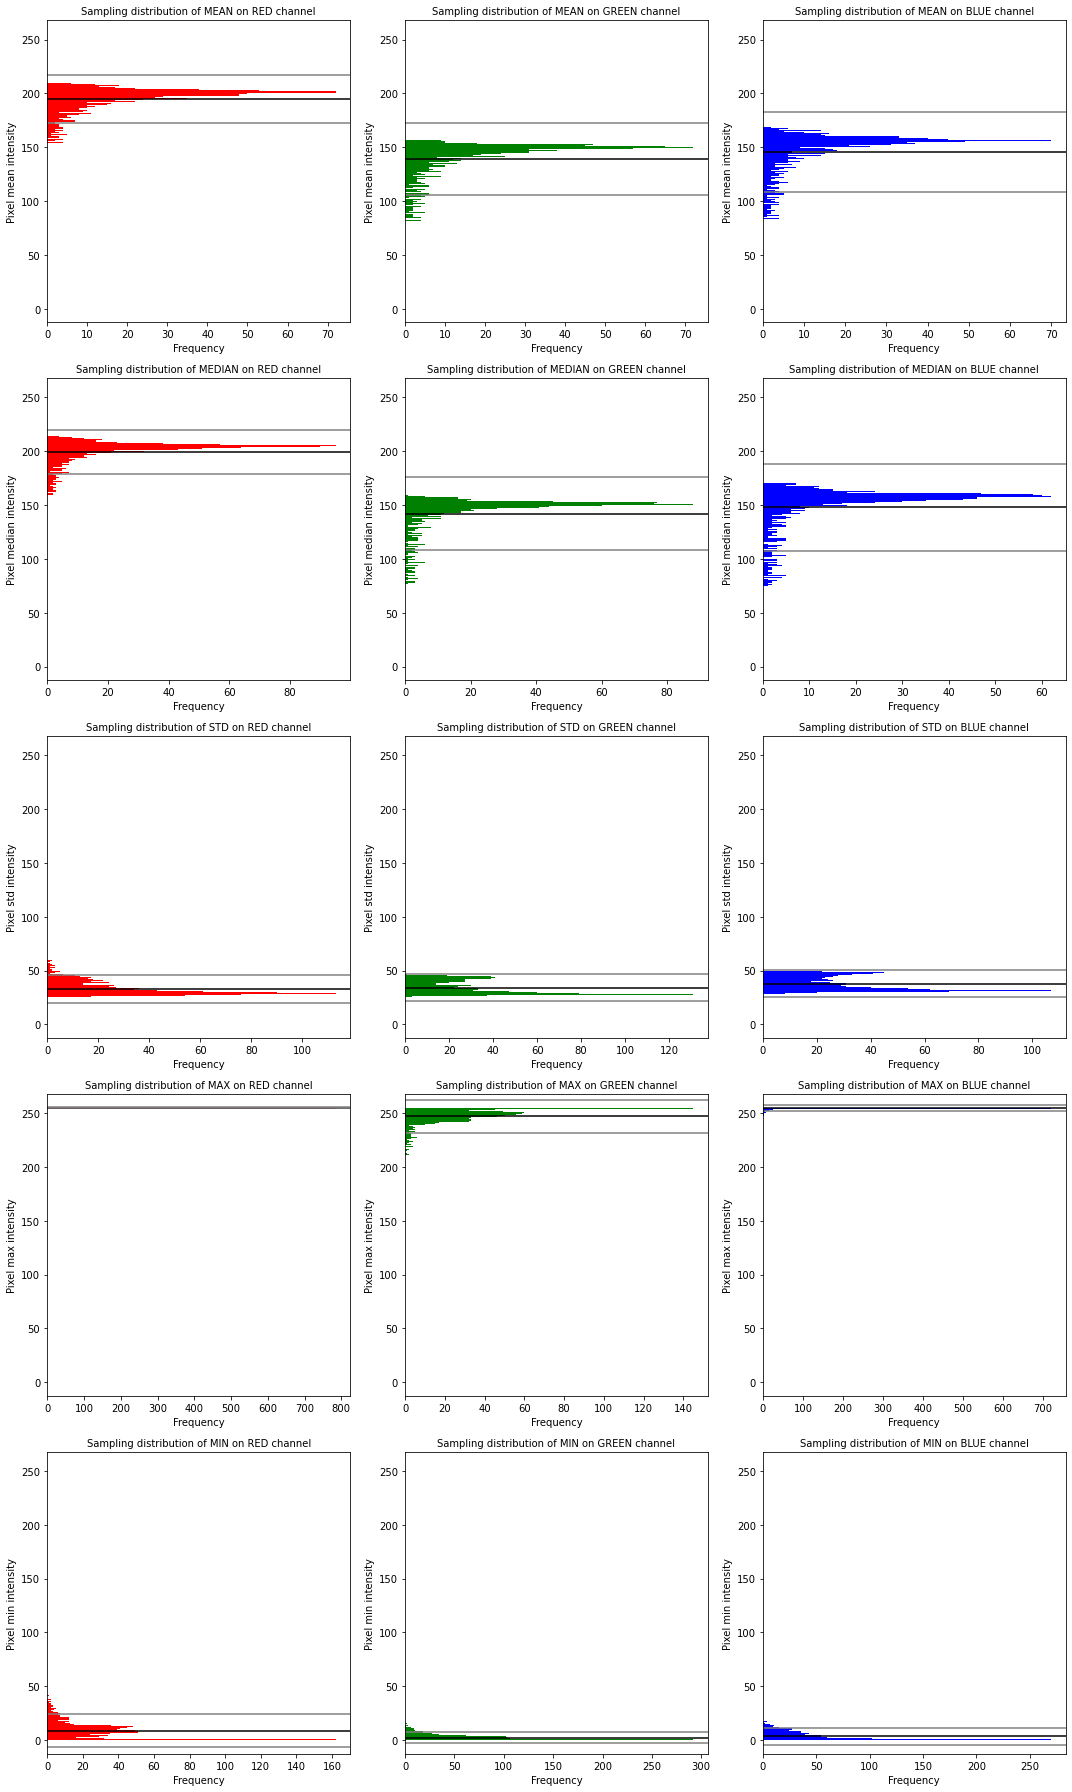

In [20]:
plot_scale = 5
std_span = 2

bins = np.arange(0,256,1)
fig, axs = plt.subplots(len(metrics),len(color_dfs))

for i, (col_name, col_df) in enumerate(color_dfs.items()):
    for j, (metric_name, metric) in enumerate(metrics.items()):
        ax = axs[j,i]
        
        dist = metric(col_df)
        ax.hist(dist, bins=bins, color=col_name, orientation="horizontal")
        
        ax.set_title("Sampling distribution of {} on {} channel".format(metric_name.upper(),col_name.upper()),fontsize=plot_scale*2)
        ax.set_ylabel("Pixel {} intensity".format(metric_name),fontsize=plot_scale*2)
        ax.set_xlabel("Frequency",fontsize=plot_scale*2)
        
        mean = dist.mean()
        std = dist.std()
        ax.axhline(mean, color="black") # Mean line

        ax.axhline(mean - std*std_span, color="grey") # Std lines
        ax.axhline(mean + std*std_span, color="grey") 
        
fig.set_size_inches(plot_scale*len(color_dfs),plot_scale*len(metrics))
fig.tight_layout()

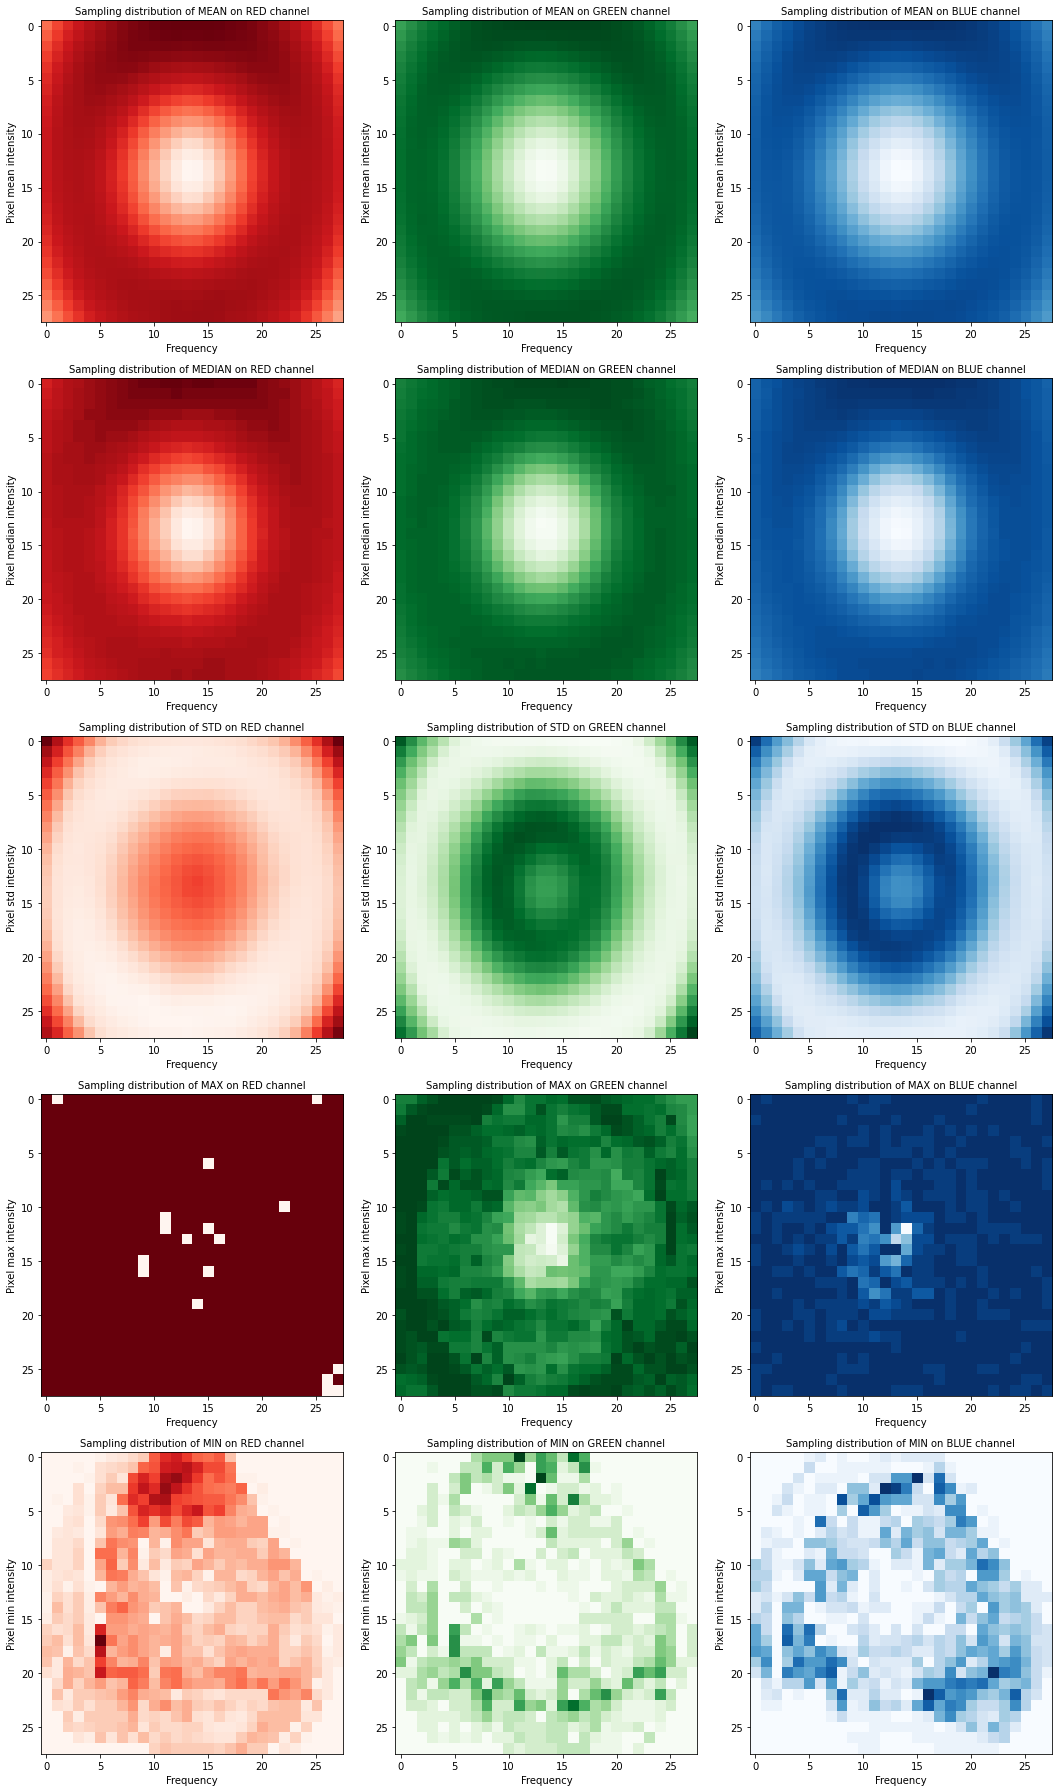

In [21]:
plot_scale = 5
std_span = 2

bins = np.arange(0,256,1)
fig, axs = plt.subplots(len(metrics),len(color_dfs))

for i, (col_name, col_df) in enumerate(color_dfs.items()):
    for j, (metric_name, metric) in enumerate(metrics.items()):
        ax = axs[j,i]
        
        dist = metric(col_df)
        dist = dist.to_numpy()
        
        dist_img = np.reshape(dist,(image_resolution,image_resolution))
        
        ax.imshow(dist_img,cmap=col_name+'s')
        
        ax.set_title("Sampling distribution of {} on {} channel".format(metric_name.upper(),col_name.upper()),fontsize=plot_scale*2)
        ax.set_ylabel("Pixel {} intensity".format(metric_name),fontsize=plot_scale*2)
        ax.set_xlabel("Frequency",fontsize=plot_scale*2)
        
        
fig.set_size_inches(plot_scale*len(color_dfs),plot_scale*len(metrics))
fig.tight_layout()

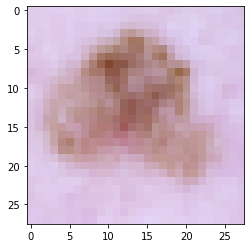

In [22]:
random_image_i = np.random.randint(len(img_train))
random_image = img_train[random_image_i]

plt.imshow(random_image)
plt.show()

# Prepare data for algo
## Normalize

In [23]:
img_test = (img_test - np.mean(img_train, axis=0))/ np.std(img_train, axis=0) # Test must be normalized against train statistics
img_train = (img_train - np.mean(img_train, axis=0))/ np.std(img_train, axis=0)

meta_test["age"] = (meta_test.age - meta_train.age.mean()) / meta_train.age.std() # Test must be normalized against train statistics
meta_train["age"] = (meta_train.age - meta_train.age.mean()) / meta_train.age.std()

In [24]:
independent_columns = ["localization","sex","age"]
dependent_column = "dx"

X_train = [meta_train[x] for x in independent_columns] + [img_train]
y_train = meta_train[dependent_column]

X_test = [meta_test[x] for x in independent_columns] + [img_test]
y_test = meta_test[dependent_column]

# Algorithm
## Image embedding

In [82]:
def make_iterable(obj):
    if hasattr(obj,"__iter__"):
        return iter(obj)
    else:
        return itools.repeat(obj)

In [83]:
class ImageEmbedder(keras.Model):
    def __init__(self,
                 input_dim,
                 output_dim,
                 output_filter_size=3,
                 filter_counts=(32,32,64),
                 filter_sizes=(3,3,3),
                 activation="relu",
                 pool_sizes=(2,2,2),
                 pool_strides=(2,2,2),
                 dropout_rate=0.3,
                 name=None,
                 **kwargs):
        super(ImageEmbedder,self).__init__(name=name,**kwargs)
        
        #Define attributes
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.output_filter_size = output_filter_size
        
        self.filter_counts = filter_counts
        self.filter_sizes = filter_sizes
        self.activation = activation
        
        self.pool_sizes = pool_sizes
        self.pool_strides = pool_strides
        
        self.dropout_rate = dropout_rate
        
        #Build model
        self.build((None,*input_dim))
    
    def build(self,input_dim):
        # Define subsampling pooling layers
        pooling_layers = [keras.layers.MaxPool2D(pool_size=pr,strides=ps) for pr, ps in zip(self.pool_sizes,self.pool_strides)]
        
        # Define convolutional layers
        conv2d_config = dict(padding="same",activation=self.activation)
        
        fc_iter = make_iterable(self.filter_counts)
        fs_iter = make_iterable(self.filter_sizes)
        conv_layers = []
        for _,fc,fs in zip(pooling_layers,fc_iter,fs_iter):
            if not (hasattr(fc,"__iter__") or
                    hasattr(fs,"__iter__")):
                conv_layers.append([keras.layers.Conv2D(fc,fs,**conv2d_config)])
            else:
                fc_iter2 = make_iterable(fc)
                fs_iter2 = make_iterable(fs)
                ls = []
                for fc2,fs2 in zip(fc_iter2,fs_iter2):
                    ls.append(keras.layers.Conv2D(fc2,fs2,**conv2d_config))
                conv_layers.append(ls)
                
        # Define regularization layers (dropout and BN)
        dropout_layers = [keras.layers.Dropout(self.dropout_rate) for _ in conv_layers]
        bn_layers = [keras.layers.BatchNormalization() for _ in conv_layers]
        
        # Define output layers
        output_conv = keras.layers.Conv2D(self.output_dim,self.output_filter_size,**conv2d_config)
        
        out_dim = list(input_dim[1:3])
        for sz_i,st_i in zip(self.pool_sizes,self.pool_strides):
            if isinstance(sz_i,int): sz_i = sz_i,sz_i
            if isinstance(st_i,int): st_i = st_i,st_i
                
            out_dim[0] = (out_dim[0] - sz_i[0] +1)/st_i[0]
            out_dim[1] = (out_dim[1] - sz_i[1] +1)/st_i[1]
            
        output_pooling = keras.layers.MaxPool2D(out_dim)
        output_flatten = keras.layers.Flatten()
        
        # Layers
        self.conv_layers = conv_layers
        self.pooling_layers = pooling_layers
        self.dropout_layers = dropout_layers
        self.bn_layers = bn_layers
        
        self.output_conv = output_conv
        self.output_pooling = output_pooling
        self.output_flatten = output_flatten
        
        super().build(input_dim)
        
    @tf.function
    def call(self,input_):
        return self._call(input_)
    
    def _call(self,input_):
        # Rename input for iteration
        x = input_
        
        # Apply initial convolution and pooling
        for convs, pooling, dropout, bn in zip(self.conv_layers,
                                               self.pooling_layers,
                                               self.dropout_layers,
                                               self.bn_layers):
            for conv in convs:
                x = conv(x)
            x = pooling(x)
            x = bn(x)
            x = dropout(x)
            
        # Apply output layers
        x = self.output_conv(x)
        x = self.output_pooling(x)
        x = self.output_flatten(x)
        
        return x 

    def get_initialized_model(self):
        input_ = keras.Input(self.input_dim)
        output = self._call(input_)
        
        return keras.Model(input_,output)
            
image_embedder = ImageEmbedder(input_dim=img_train.shape[1:],
                               output_dim=64,
                               filter_counts=(32,48,64),
                               filter_sizes=(3,3,3),
                               pool_sizes=(2,2,2),
                               pool_strides=(2,2,2))

In [84]:
image_embedder.summary()

Model: "image_embedder_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          multiple                  896       
_________________________________________________________________
conv2d_125 (Conv2D)          multiple                  13872     
_________________________________________________________________
conv2d_126 (Conv2D)          multiple                  27712     
_________________________________________________________________
max_pooling2d_124 (MaxPoolin multiple                  0         
_________________________________________________________________
max_pooling2d_125 (MaxPoolin multiple                  0         
_________________________________________________________________
max_pooling2d_126 (MaxPoolin multiple                  0         
_________________________________________________________________
dropout_117 (Dropout)        multiple            

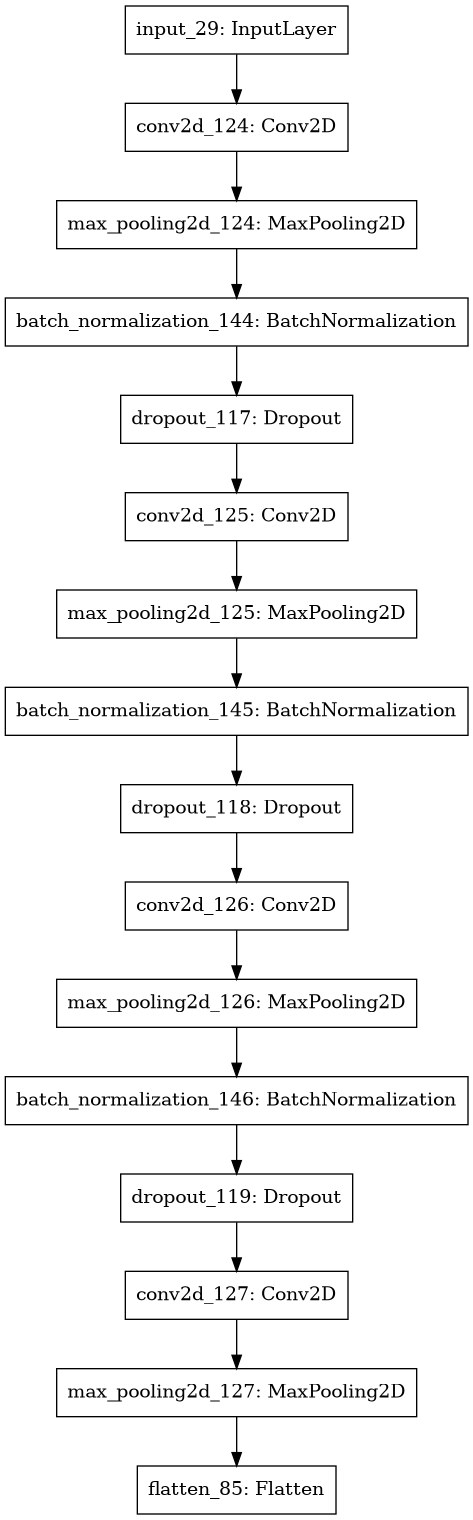

In [85]:
keras.utils.plot_model(image_embedder.get_initialized_model())

## Classification model

In [86]:
class CancerNN(keras.Model):
    def __init__(self,
                 n_classes=len(meta_train.dx.unique()),
                 hidden_units=(64,),
                 activation="relu",
                 dropout_rate=0.3,
                 combination_layer=keras.layers.Add,
                 image_embedder=ImageEmbedder,
                 compilation_args=dict(loss=keras.losses.SparseCategoricalCrossentropy(),
                                       optimizer=keras.optimizers.Adam(),
                                       metrics=["accuracy"]),
                 name=None,
                 **kwargs):
        super(CancerNN,self).__init__(name=name, **kwargs)
        
        # Define attributes
        self.n_classes = n_classes
        
        self.hidden_units = hidden_units
        self.activation = activation
        
        self.dropout_rate = dropout_rate
        
        self.combination_layer = combination_layer
        self.image_embedder = image_embedder
        
        # Autobuild model
        self.build([(None,1),(None,1),(None,1),(None,*img_train.shape[1:])])
        self.compile(**compilation_args)
        
    def build(self,input_dim):
        # Embeddings
        loc_embedding = keras.layers.Embedding(input_dim=len(meta_df_e.localization.unique()), 
                                               output_dim=self.hidden_units[0], 
                                               name="localization_embedding")
        sex_embedding = keras.layers.Embedding(input_dim=len(meta_df_e.sex.unique()), 
                                               output_dim=self.hidden_units[0], 
                                               name="sex_embedding")
        age_embedding = keras.layers.Dense(units=self.hidden_units[0],
                                          activation=self.activation, 
                                          name="age_dense")
        #Image
        image_embedding = self.image_embedder(input_dim[-1][1:],self.hidden_units[0])
        
        
        # Flattening
        loc_flatten = keras.layers.Flatten()
        sex_flatten = keras.layers.Flatten()
        
        # Combining
        combine = self.combination_layer()
        
        # Intermediate hidden layers
        hidden_layers = [keras.layers.Dense(hd,activation=self.activation) for hd in self.hidden_units[1:]]
        bn_layers = [keras.layers.BatchNormalization() for _ in hidden_layers]
        dropout_layers = [keras.layers.Dropout(self.dropout_rate) for _ in hidden_layers]
        
        # Output layers
        output_bn = keras.layers.BatchNormalization()
        output_dense = keras.layers.Dense(self.n_classes,activation="linear")
        output_softmax = keras.layers.Softmax()
        
        
        # Layers
        self.loc_embedding = loc_embedding
        self.sex_embedding = sex_embedding
        self.age_embedding = age_embedding
        self.image_embedding = image_embedding
        
        self.loc_flatten = loc_flatten
        self.sex_flatten = sex_flatten
        
        self.combine = combine
        
        self.hidden_layers = hidden_layers
        self.bn_layers = bn_layers
        self.dropout_layers = dropout_layers
        
        self.output_bn = output_bn
        self.output_dense = output_dense
        self.output_softmax = output_softmax
        
        super().build(input_dim)
        
        
    @tf.function
    def call(self, inputs):
        return self._call(inputs)
    

    def _call(self,inputs):
        loc_in, sex_in, age_in, img_in = inputs
        
        loc_rep = self.loc_embedding(loc_in)
        sex_rep = self.sex_embedding(sex_in)
        age_rep = self.age_embedding(age_in)
        img_rep = self.image_embedding(img_in)
        
        loc_rep = self.loc_flatten(loc_rep)
        sex_rep = self.sex_flatten(sex_rep)
        
        reps = [loc_rep, sex_rep, age_rep, img_rep]
        c_reps = self.combine(reps)
        
        x = c_reps
        for hl,bn,do in zip(self.hidden_layers,self.bn_layers,self.dropout_layers):
            x = bn(x)
            x = do(x)
            x = hl(x)
            
        x = self.output_bn(x)
        x = self.output_dense(x)
        x = self.output_softmax(x)
        
        return x
    
    def get_initialized_model(self):
        loc_in = keras.Input(1)
        sex_in = keras.Input(1)
        age_in = keras.Input(1)
        img_in = keras.Input(img_train.shape[1:])
        
        comb_in = [loc_in, sex_in, age_in, img_in]
        
        output = self._call(comb_in)
        
        return keras.Model(comb_in,output)

    def fit(self,
            X,y,
            shuffle=True,
            batch_size=64,
            epochs=100,
            validation_split=0.2,
            callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                     patience=20,
                                                     restore_best_weights=True,
                                                     verbose=0)],
            verbose=0,
            **kwargs):
        return super().fit(X,y,
                   shuffle=shuffle,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_split=validation_split,
                   callbacks=callbacks,
                   verbose=verbose,
                   **kwargs)
model = CancerNN()

In [87]:
model.summary()

Model: "cancer_nn_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
localization_embedding (Embe multiple                  960       
_________________________________________________________________
sex_embedding (Embedding)    multiple                  192       
_________________________________________________________________
age_dense (Dense)            multiple                  128       
_________________________________________________________________
image_embedder_32 (ImageEmbe multiple                  66080     
_________________________________________________________________
flatten_87 (Flatten)         multiple                  0         
_________________________________________________________________
flatten_88 (Flatten)         multiple                  0         
_________________________________________________________________
add_27 (Add)                 multiple                 

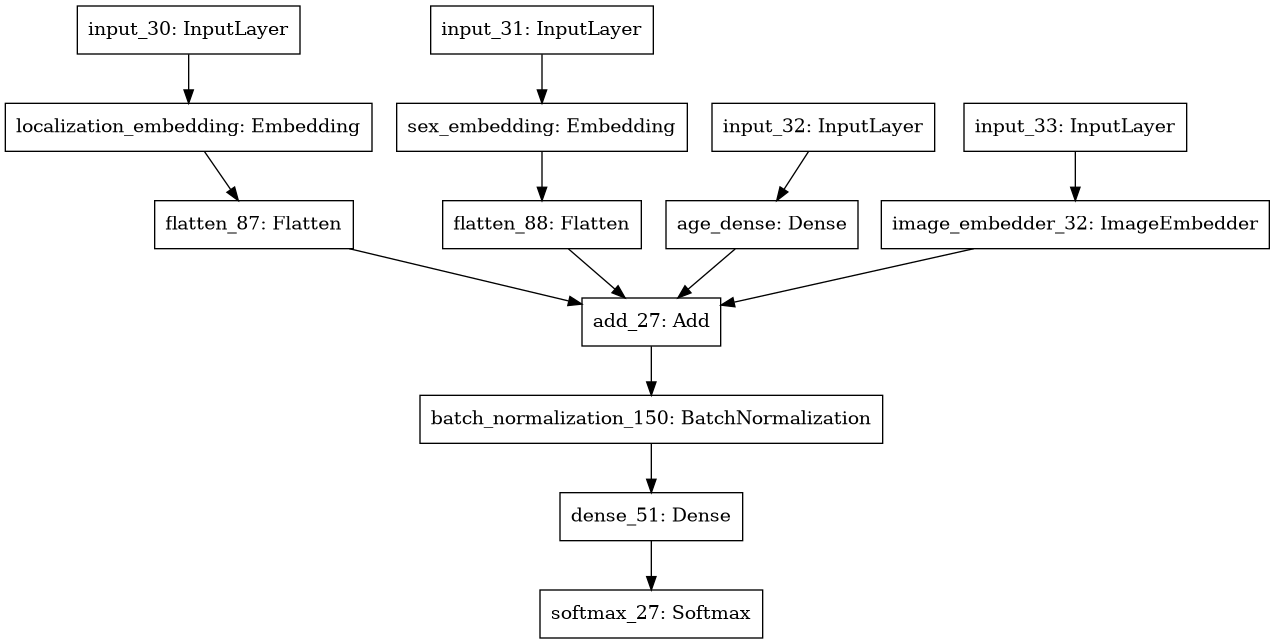

In [88]:
keras.utils.plot_model(model.get_initialized_model())

## Upper Baseline

In [89]:
model.fit(X_train, y_train, verbose=1)

Epoch 1/100
101/101 [==============================] - 1s 4ms/step - loss: 1.3023 - accuracy: 0.6182 - val_loss: 1.0127 - val_accuracy: 0.7024
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 0.8385 - accuracy: 0.7454 - val_loss: 0.7794 - val_accuracy: 0.7405
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.7789 - val_loss: 0.6906 - val_accuracy: 0.7617
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5875 - accuracy: 0.7939 - val_loss: 0.6620 - val_accuracy: 0.7648
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5356 - accuracy: 0.8065 - val_loss: 0.6411 - val_accuracy: 0.7767
Epoch 6/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5098 - accuracy: 0.8176 - val_loss: 0.6443 - val_accuracy: 0.7773
Epoch 7/100
101/101 [==============================] - 0s 3ms/step - loss: 0.4495 - accuracy: 0.8429 - val_loss: 0.6740 - val_accuracy: 0.7667

In [90]:
pred_proba = model.predict(X_test)
pred_max = np.argmax(pred_proba,axis=1)
print(confusion_matrix(y_test,pred_max))
print(classification_report(y_test,pred_max))

[[  23    6   12    1    4   14    0]
 [  17   44   17    2    7   16    3]
 [   8    5  128    0   20   70    0]
 [   2    2    1    6    0   10    0]
 [   4    3   40    2   85  108    0]
 [   6    3   24    4   52 1222    1]
 [   0    4    1    0    4    7   15]]
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        60
           1       0.66      0.42      0.51       106
           2       0.57      0.55      0.56       231
           3       0.40      0.29      0.33        21
           4       0.49      0.35      0.41       242
           5       0.84      0.93      0.89      1312
           6       0.79      0.48      0.60        31

    accuracy                           0.76      2003
   macro avg       0.59      0.49      0.53      2003
weighted avg       0.74      0.76      0.75      2003



# Pseudo-Labelling

In [91]:
class PseudoLabeller():
    def __init__(self, 
                 model_constructor, 
                 labeled_data, 
                 unlabeled_data):
        self.model_constructor = model_constructor
        self.labeled_data = labeled_data
        self.unlabeled_data = unlabeled_data
        
        X_train, _ = self.labeled_data
        if isinstance(X_train,list):
            self.all_data = [np.concatenate((x_lb,x_ulb),axis=0) for x_lb,x_ulb in zip(X_train,self.unlabeled_data)]
        else:
            self.all_data = np.concatenate((X_train,self.unlabeled_data),axis=0)
    
    def fit(self):
        self.base_model = self.model_constructor()

        X_train, y_train = self.labeled_data 
        
        self.base_model.fit(X_train,y_train)
        
        # compute pseudo-labels
        self.pseudo_y = self.base_model.predict(self.unlabeled_data)
        self.pseudo_y = np.argmax(self.pseudo_y, axis=1)
        
        self.all_y = np.concatenate((y_train,self.pseudo_y))
        
        # train with pseudo-labelled data
        self.pl_model = self.model_constructor()
        self.pl_model.fit(self.all_data,self.all_y)
        


In [92]:
annotation_ratios = [0.01,0.05,0.1,0.2,0.5]

pls = []
for ar in tqdm(annotation_ratios):
    labeled_samples = int(ar * meta_train.shape[0])
    
    labeled_data = [x[:labeled_samples] for x in X_train], y_train[:labeled_samples]
    unlabeled_data = [x[labeled_samples:] for x in X_train]
    
    pl = PseudoLabeller(CancerNN,labeled_data,unlabeled_data)
    pl.fit()
    
    pls.append(pl)

100%|██████████| 5/5 [01:02<00:00, 12.47s/it]


## Evaluation

In [93]:
base_model_eval = [pl.base_model.evaluate(X_test, y_test)[1] for pl in pls]
pl_model_eval = [pl.pl_model.evaluate(X_test, y_test)[1] for pl in pls]

63/63 [==============================] - 0s 2ms/step - loss: 0.7488 - accuracy: 0.7544


In [94]:
upper_baseline_eval = model.evaluate(X_test,y_test)[1]

63/63 [==============================] - 0s 1ms/step - loss: 0.7619 - accuracy: 0.7604


In [95]:
print(base_model_eval)
print(pl_model_eval)

[0.48277583718299866, 0.6889665722846985, 0.717923104763031, 0.7094358205795288, 0.7623564600944519]
[0.4937593638896942, 0.6874687671661377, 0.7174238562583923, 0.7219171524047852, 0.7543684244155884]


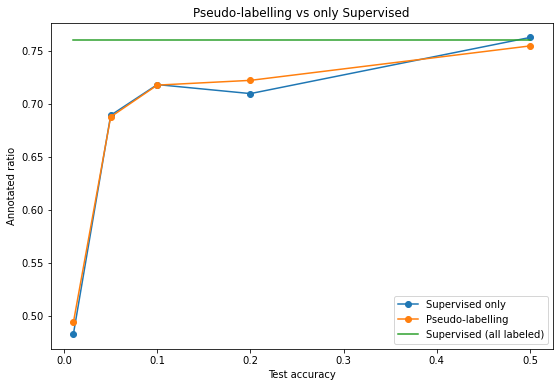

In [96]:
plt.figure(figsize=(9,6))

plt.plot(annotation_ratios,base_model_eval,marker='o')
plt.plot(annotation_ratios,pl_model_eval,marker='o')
plt.plot(annotation_ratios,[upper_baseline_eval]*len(annotation_ratios))

plt.title("Pseudo-labelling vs only Supervised")
plt.ylabel("Annotated ratio")
plt.xlabel("Test accuracy")

plt.legend(["Supervised only","Pseudo-labelling","Supervised (all labeled)"])

plt.show()

In [40]:
pseudo_labeller.pl_model.evaluate(X_test, y_test)

NameError: name 'pseudo_labeller' is not defined